# Subsampling

Another problem is that there are much more negatives than positives in the dataset (i.e. more non-fradulent than fraudulent transactions). By **using less negative samples**, we can balance the dataset again.

## Train

> **Note**: you can download the dataset [here](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud). Create a new folder called `data` in the directory of this notebook and move the downloaded csv file into that folder. Next, rename the csv file to `creditcard_fraud_dataset.csv`.

In [1]:
from lib.creditcard_fraud_dataset import get_train_test_dfs

df_train, df_test = get_train_test_dfs()

We will use **the same number of negatives and positives**. With the argument `n_neg`, we can set the number of negatives that will be chosen randomly for training.

In [2]:
# Since the positives have class 1, we can count
# the number of positives by summing the "Class" column
n_pos = df_train['Class'].sum()

In [3]:
from lib.cs_train import train_clf


clf_subsamp = train_clf(
    df_train,
    n_neg=n_pos
)

clf_no_subsamp = train_clf(
    df_train,
    n_neg=-1
)

## Evaluate

In [4]:
from lib.cs_eval import evaluate_clf

eval_metrics_subsamp = evaluate_clf(clf_subsamp, df_test)
eval_metrics_no_subsamp = evaluate_clf(clf_no_subsamp, df_test)

In [5]:
import pandas as pd

df = pd.DataFrame([
    {
        'method': 'Subsampled',
        **eval_metrics_subsamp
    },
    {
        'method': 'Not Subsampled',
        **eval_metrics_no_subsamp
    }
])

In [6]:
df

,method,cost_precision,cost_recall,tp_amount,fp_amount,fn_amount,net
0,Subsampled,0.738148,0.917750,28685.72,10176.0,2570.85,15938.87
1,Not Subsampled,0.997766,0.514306,16075.45,36.0,15181.12,858.33


Text(0.5, 1.0, 'Cost Recall')

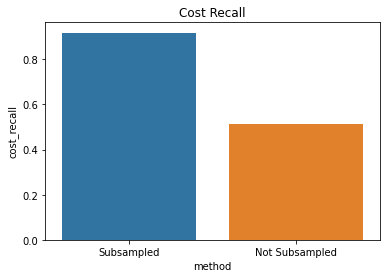

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=df, x='method', y='cost_recall')
plt.title('Cost Recall')

Text(0.5, 1.0, 'Cost Precision')

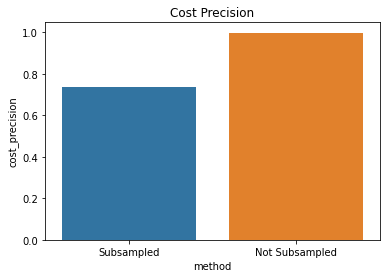

In [8]:
sns.barplot(data=df, x='method', y='cost_precision')
plt.title('Cost Precision')